# Short-term Meter-level Load Forecasting
<br>
<img src="kgce.jpg">
<br>
<font color=red>About-</font> <font color=black>With the development of smart meters, electric utilities can obtain precise and detailed data of single consumers. This has lead to the generation of various big data sets with previously unattainable information leading to efficient smart grid performance in areas such as load forecasting. Accurate load forecasting promotes effective functioning of smart grids and power system ultimately leading to proper utilization of resources and avoidance of power outages. Meter level prediction, also known as domestic level forecasting, for short period of time finds applications in load scheduling, management of demand response and storage systems. This project uses of an approach combined using Seasonal Autoregressive Integrated Moving Average Exogenous (SARIMAX) and Long Short Term Memory networks (LSTM) with regression models to predict daily energy consumption of customers located in London area </font>

In [27]:
#!pip install pandas
#!pip install matplotlib
#!pip install statsmodels
#!pip install pyflux
#!pip install sklearn
#!pip install tensorflow
#!pip install keras

In [28]:
import warnings
warnings.simplefilter('ignore')

from ipywidgets import interact
import ipywidgets as widgets
import os
import math
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import pyplot
import pandas as pd
from pandas import datetime
from pandas.plotting import autocorrelation_plot

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.simplefilter('ignore')
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import warnings
warnings.simplefilter('ignore')

## Relationship of weather conditions with electricity consumption

In [29]:
energy = pd.read_csv('energy.csv')

housecount = energy.groupby('day')[['LCLid']].nunique()

energy = energy.groupby('day')[['energy_sum']].sum()
energy = energy.merge(housecount, on = ['day'])
energy = energy.reset_index()

energy.day = pd.to_datetime(energy.day,format='%Y-%m-%d').dt.date
energy['avg_energy'] =  energy['energy_sum']/energy['LCLid']


weather = pd.read_csv('weather_daily_darksky.csv')

weather['day']=  pd.to_datetime(weather['time'])
weather['day']=  pd.to_datetime(weather['day'],format='%Y%m%d').dt.date
weather = weather[['temperatureMax', 'windBearing', 'dewPoint', 'cloudCover', 'windSpeed',
       'pressure', 'apparentTemperatureHigh', 'visibility', 'humidity',
       'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex',
       'temperatureLow', 'temperatureMin', 'temperatureHigh',
       'apparentTemperatureMin', 'moonPhase','day']]
weather = weather.dropna()

weather_energy = energy.merge(weather,on='day')

###  <font color='blue'>1. Energy Consumption and Temperature</font>

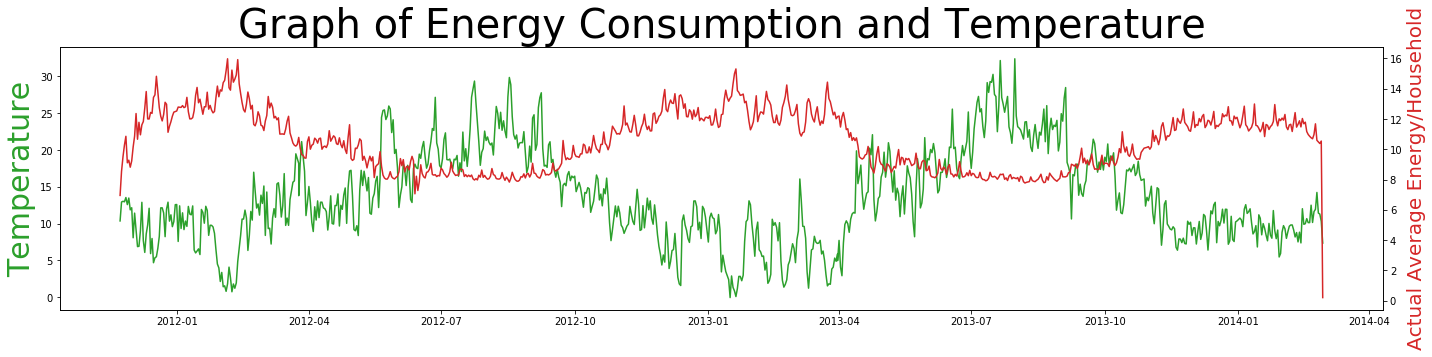

In [30]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.temperatureMax, color = 'tab:green')
#ax1.plot(weather_energy.day, weather_energy.temperatureMin, color = 'tab:pink')
ax1.set_ylabel('Temperature', color = 'tab:green',size = 30)
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:red')
ax2.set_ylabel('Actual Average Energy/Household',color = 'tab:red',size = 20)
#ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))
plt.title('Graph of Energy Consumption and Temperature',size = 40)
fig.tight_layout()
plt.show()

###  <font color='blue'>2. Energy Consumption and Humidity</font>

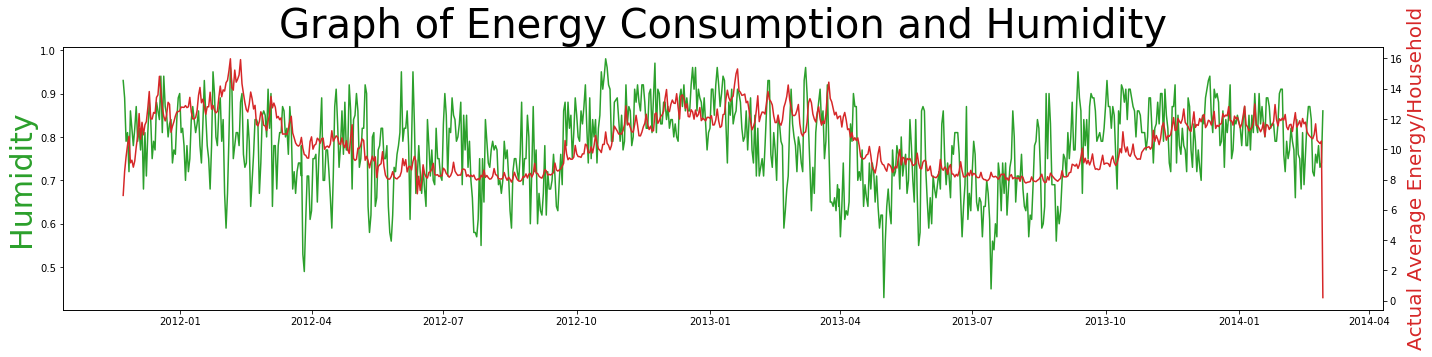

In [31]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.humidity, color = 'tab:green')
ax1.set_ylabel('Humidity',color = 'tab:green',size = 30)
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:red')
ax2.set_ylabel('Actual Average Energy/Household',color = 'tab:red',size = 20)
plt.title('Graph of Energy Consumption and Humidity',size = 40)
fig.tight_layout()
plt.show()

###  <font color='blue'>3. Energy Consumption and  Cloud Cover</font>

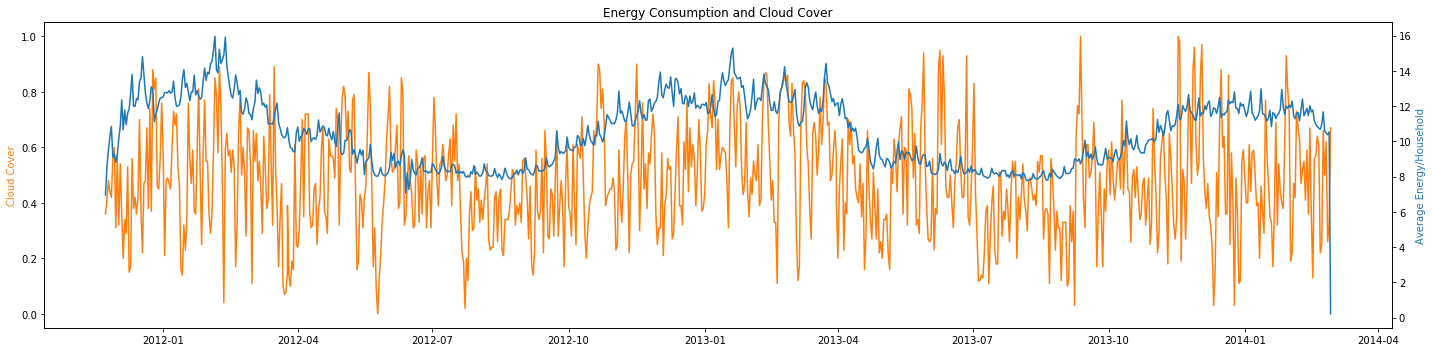

In [32]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.cloudCover, color = 'tab:orange')
ax1.set_ylabel('Cloud Cover',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and Cloud Cover')
fig.tight_layout()
plt.show()

###  <font color='blue'>4. Energy Consumption and Visibility</font>

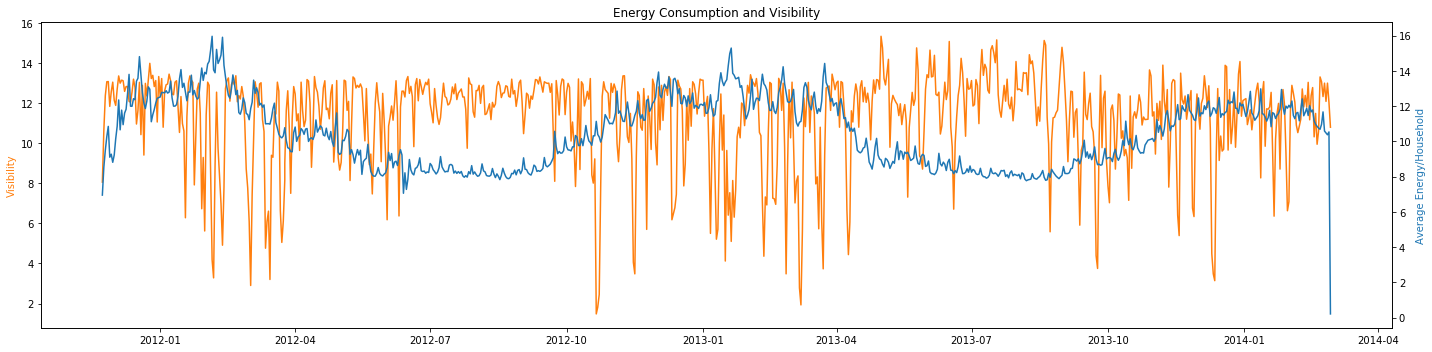

In [33]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.visibility, color = 'tab:orange')
ax1.set_ylabel('Visibility',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and Visibility')
fig.tight_layout()
plt.show()

###  <font color='blue'>5. Energy Consumption and Wind Speed</font>

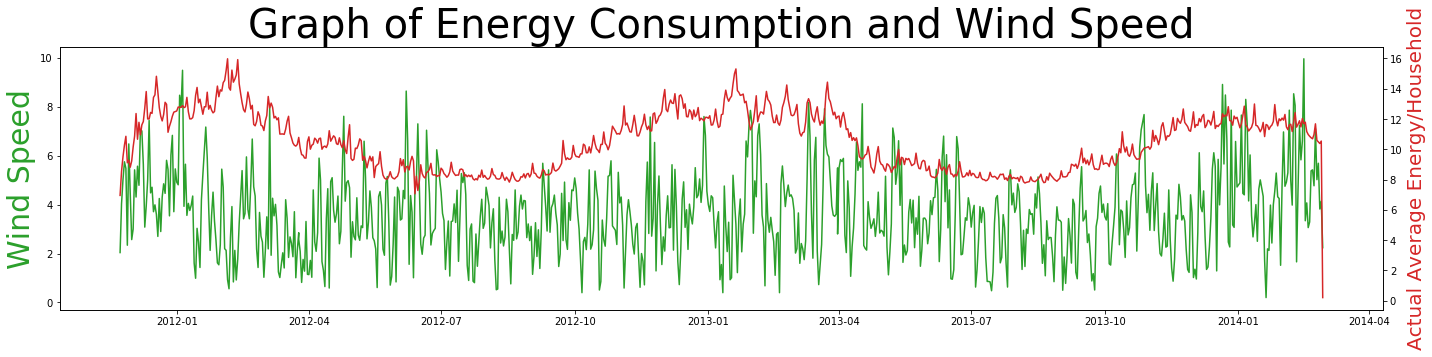

In [34]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.windSpeed, color = 'tab:green')
ax1.set_ylabel('Wind Speed',color = 'tab:green',size = 30)
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:red')
ax2.set_ylabel('Actual Average Energy/Household',color = 'tab:red',size = 20)
plt.title('Graph of Energy Consumption and Wind Speed',size = 40)
fig.tight_layout()
plt.show()

###  <font color='blue'>6. Energy Consumption and UV Index</font>

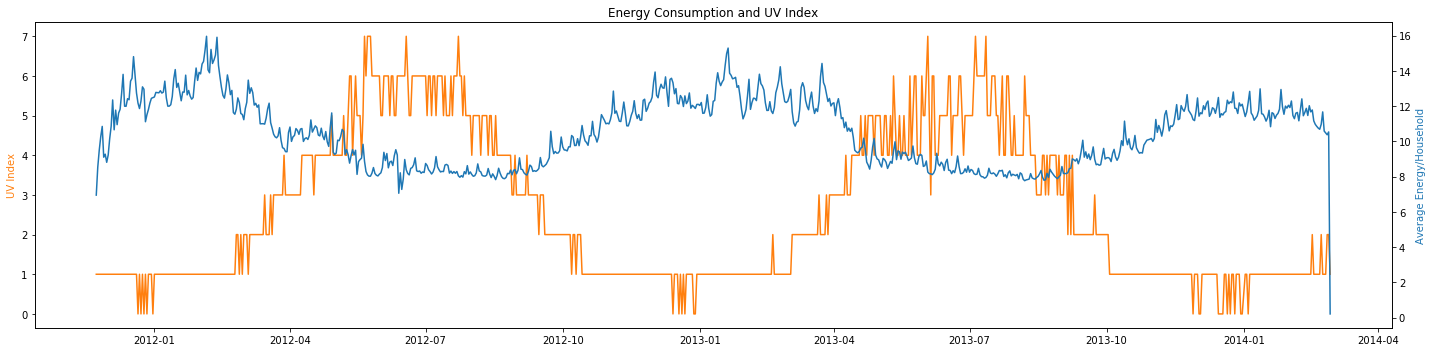

In [35]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.uvIndex, color = 'tab:orange')
ax1.set_ylabel('UV Index',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and UV Index')
fig.tight_layout()
plt.show()

###  <font color='blue'>7. Energy Consumption and Dew Point</font>

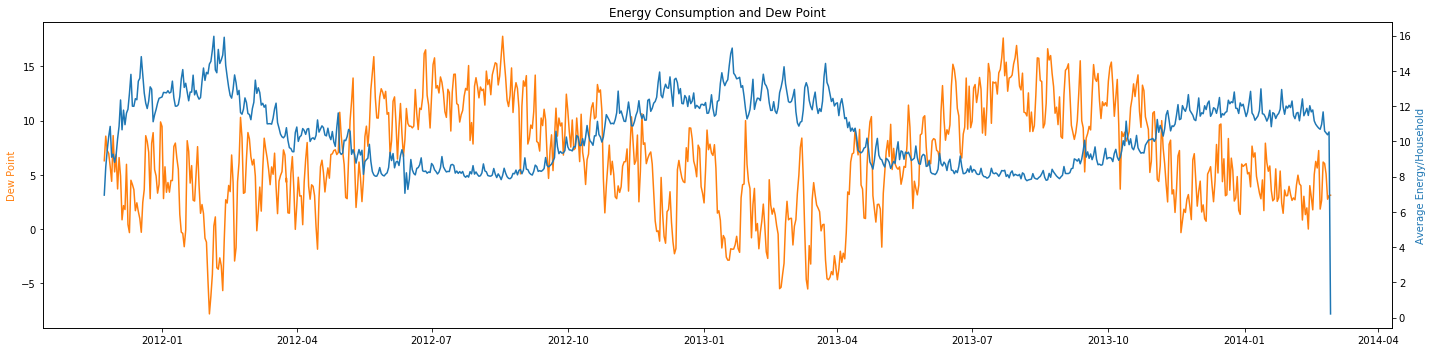

In [36]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.dewPoint, color = 'tab:orange')
ax1.set_ylabel('Dew Point',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and Dew Point')
fig.tight_layout()
plt.show()

### Correlation of weather parameters

In [37]:
cor_matrix = weather_energy[['avg_energy','temperatureMax','dewPoint', 'cloudCover', 'windSpeed','pressure', 'visibility', 'humidity','uvIndex', 'moonPhase']].corr()
cor_matrix

,avg_energy,temperatureMax,dewPoint,cloudCover,windSpeed,pressure,visibility,humidity,uvIndex,moonPhase
avg_energy,1.000000,-0.846965,-0.755901,0.241779,0.149624,-0.028851,-0.246404,0.361237,-0.733171,-0.031716
temperatureMax,-0.846965,1.000000,0.865038,-0.333409,-0.153602,0.118933,0.259108,-0.404899,0.696497,0.003636
dewPoint,-0.755901,0.865038,1.000000,-0.025207,-0.092212,-0.028121,0.042633,0.055514,0.486692,-0.008239
cloudCover,0.241779,-0.333409,-0.025207,1.000000,0.170235,-0.101079,-0.330177,0.480056,-0.248695,-0.062126
windSpeed,0.149624,-0.153602,-0.092212,0.170235,1.000000,-0.344354,0.281088,-0.042391,-0.152634,-0.023273
pressure,-0.028851,0.118933,-0.028121,-0.101079,-0.344354,1.000000,-0.012508,-0.250941,0.100774,0.038462
visibility,-0.246404,0.259108,0.042633,-0.330177,0.281088,-0.012508,1.000000,-0.578130,0.240485,0.062813
humidity,0.361237,-0.404899,0.055514,0.480056,-0.042391,-0.250941,-0.578130,1.000000,-0.533919,-0.013997
uvIndex,-0.733171,0.696497,0.486692,-0.248695,-0.152634,0.100774,0.240485,-0.533919,1.000000,0.012833
moonPhase,-0.031716,0.003636,-0.008239,-0.062126,-0.023273,0.038462,0.062813,-0.013997,0.012833,1.000000


### Weather Data into clusters

In [38]:
scaler = MinMaxScaler()
weather_scaled = scaler.fit_transform(weather_energy[['temperatureMax','humidity','windSpeed']])

kmeans = KMeans(n_clusters=3, max_iter=600, algorithm = 'auto')
kmeans.fit(weather_scaled)
weather_energy['weather_cluster'] = kmeans.labels_

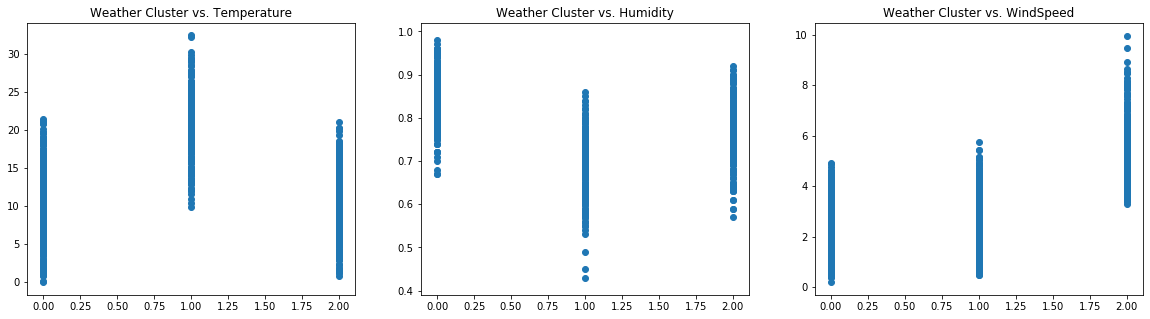

In [39]:
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.scatter(weather_energy.weather_cluster,weather_energy.temperatureMax)
plt.title('Weather Cluster vs. Temperature')
plt.subplot(1, 3, 2)
plt.scatter(weather_energy.weather_cluster,weather_energy.humidity)
plt.title('Weather Cluster vs. Humidity')
plt.subplot(1, 3, 3)
plt.scatter(weather_energy.weather_cluster,weather_energy.windSpeed)
plt.title('Weather Cluster vs. WindSpeed')

plt.show()

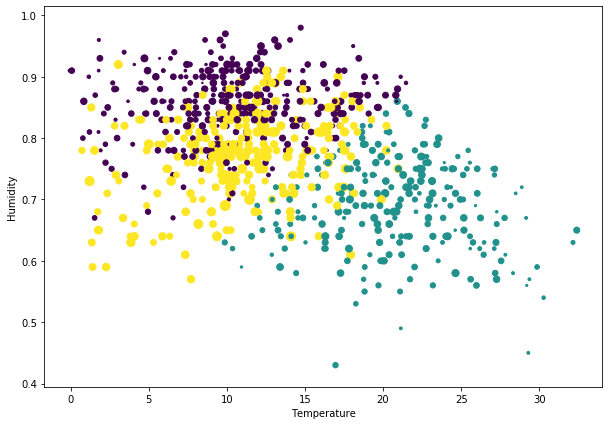

In [40]:
fig, ax1 = plt.subplots(figsize = (10,7))
ax1.scatter(weather_energy.temperatureMax, 
            weather_energy.humidity, 
            s = weather_energy.windSpeed*10,
            c = weather_energy.weather_cluster)
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Humidity')
plt.show()

In [41]:
holiday = pd.read_csv('uk_bank_holidays.csv')
holiday['Bank holidays'] = pd.to_datetime(holiday['Bank holidays'],format='%Y-%m-%d').dt.date

weather_energy = weather_energy.merge(holiday, left_on = 'day',right_on = 'Bank holidays',how = 'left')
weather_energy['holiday_ind'] = np.where(weather_energy['Bank holidays'].isna(),0,1)

weather_energy['Year'] = pd.DatetimeIndex(weather_energy['day']).year  
weather_energy['Month'] = pd.DatetimeIndex(weather_energy['day']).month
weather_energy.set_index(['day'],inplace=True)

# Time series forcasting algorithms

## <font color=red>1. Seasonal Autoregressive Integrated Moving Average with external variables (_SARIMAX_) </font>

In [1]:
import warnings; warnings.simplefilter('ignore')
model_data = weather_energy[['avg_energy','weather_cluster','holiday_ind']]
train = model_data.iloc[0:(len(model_data)-30)]
test = model_data.iloc[len(train):(len(model_data)-1)]

train['avg_energy'].plot(figsize=(25,4))
test['avg_energy'].plot(figsize=(25,4))


endog = train['avg_energy']
exog = sm.add_constant(train[['weather_cluster','holiday_ind']])

mod = sm.tsa.statespace.SARIMAX(endog=endog, exog=exog, order=(7,1,1),seasonal_order=(1,1, 0, 12),trend='c')
model_fit = mod.fit()
model_fit.summary()


predict = model_fit.predict(start = len(train),end = len(train)+len(test)-1,exog = sm.add_constant(test[['weather_cluster','holiday_ind']]))
test['predicted_sarimax'] = predict.values

test['residual_sarimax'] = abs(test['avg_energy']-test['predicted_sarimax'])
MAE = test['residual_sarimax'].sum()/len(test)
MAPE = (abs(test['residual_sarimax'])/test['avg_energy']).sum()*100/len(test)
print("mean absolute error:", MAE)
print("mean absolute percentage error:", MAPE)

model_fit.fittedvalues.plot(figsize = (30,5))
test.predicted_sarimax.plot()


test

NameError: name 'weather_energy' is not defined

## <font color=red> 2. Long short-term memory (_LSTM_)</font>

Epoch 1/100
 - 0s - loss: 10.2878
Epoch 2/100
 - 0s - loss: 9.4047
Epoch 3/100
 - 0s - loss: 8.5391
Epoch 4/100
 - 0s - loss: 7.7223
Epoch 5/100
 - 0s - loss: 6.9149
Epoch 6/100
 - 0s - loss: 6.1683
Epoch 7/100
 - 0s - loss: 5.4972
Epoch 8/100
 - 0s - loss: 4.8316
Epoch 9/100
 - 0s - loss: 4.1037
Epoch 10/100
 - 0s - loss: 3.4423
Epoch 11/100
 - 0s - loss: 2.7913
Epoch 12/100
 - 0s - loss: 2.1100
Epoch 13/100
 - 0s - loss: 1.7996
Epoch 14/100
 - 0s - loss: 1.6820
Epoch 15/100
 - 0s - loss: 1.6292
Epoch 16/100
 - 0s - loss: 1.5929
Epoch 17/100
 - 0s - loss: 1.5609
Epoch 18/100
 - 0s - loss: 1.5300
Epoch 19/100
 - 0s - loss: 1.5020
Epoch 20/100
 - 0s - loss: 1.4790
Epoch 21/100
 - 0s - loss: 1.4567
Epoch 22/100
 - 0s - loss: 1.4272
Epoch 23/100
 - 0s - loss: 1.3783
Epoch 24/100
 - 0s - loss: 1.3156
Epoch 25/100
 - 0s - loss: 1.2666
Epoch 26/100
 - 0s - loss: 1.2205
Epoch 27/100
 - 0s - loss: 1.1785
Epoch 28/100
 - 0s - loss: 1.1411
Epoch 29/100
 - 0s - loss: 1.1069
Epoch 30/100
 - 0s - l

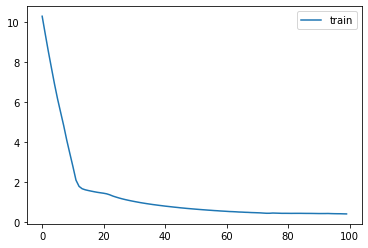

In [43]:
np.random.seed(11)
dataframe = weather_energy.loc[:,'avg_energy']
dataset = dataframe.values
dataset = dataset.astype('float32')

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

reframed = series_to_supervised(dataset, 7,1)

reframed['weather_cluster'] = weather_energy.weather_cluster.values[7:]
reframed['holiday_ind']= weather_energy.holiday_ind.values[7:]

reframed = reframed.reindex(['weather_cluster', 'holiday_ind','var1(t-7)', 'var1(t-6)', 'var1(t-5)', 'var1(t-4)', 'var1(t-3)','var1(t-2)', 'var1(t-1)', 'var1(t)'], axis=1)
reframed = reframed.values


#scaler = MinMaxScaler()
#reframed = scaler.fit_transform(reframed)

train = reframed[:(len(reframed)-30), :]
test_lstm = reframed[(len(reframed)-30):len(reframed), :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test_lstm[:, :-1], test_lstm[:, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))



model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

history = model.fit(train_X, train_y, epochs=100, batch_size=72, verbose=2, shuffle=False)

pyplot.plot(history.history['loss'], label='train')
pyplot.legend()
pyplot.show()

Test Root Mean Square Error: 1.974


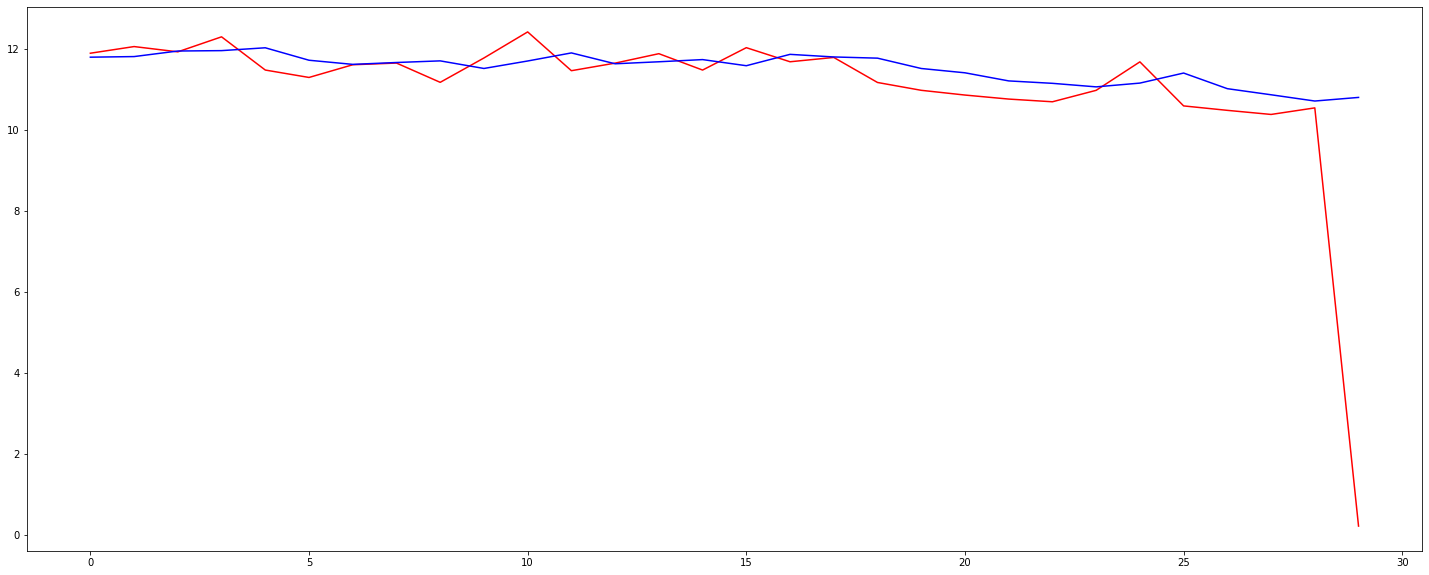

,predicted,avg_energy
0,11.789304,11.886982
1,11.804159,12.051321
2,11.941473,11.921217
3,11.951046,12.291726
4,12.021349,11.471760
5,11.713793,11.288728
6,11.611765,11.602300
7,11.657823,11.644153
8,11.698112,11.168278
9,11.510633,11.769625


In [44]:
yhat = model.predict(test_X)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[2])
inv_yhat = np.concatenate((yhat, test_X), axis=1)
#inv_yhat = scaler.inverse_transform(inv_yhat)

test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X), axis=1)
#inv_y = scaler.inverse_transform(inv_y)

act = [i[0] for i in inv_y]
pred = [i[0] for i in inv_yhat]
rmse = math.sqrt(mean_squared_error(act, pred))
print('Test Root Mean Square Error: %.3f' % rmse)

predicted_lstm = pd.DataFrame({'predicted':pred,'avg_energy':act})
predicted_lstm['avg_energy'].plot(figsize=(25,10),color = 'red')
predicted_lstm['predicted'].plot(color = 'blue')
plt.show()

predicted_lstm

## <font color=red> 3. Hybrid combination of SARIMAX and LSTM </font>

In [45]:
#Combine LSTM + SARIMAX

same_ds = series_to_supervised(test['avg_energy'], 7,1)

same_ds['weather_cluster'] = test.weather_cluster.values[7:]
same_ds['holiday_ind']= test.holiday_ind.values[7:]

same_ds = same_ds.reindex(['weather_cluster', 'holiday_ind','var1(t-7)', 'var1(t-6)', 'var1(t-5)', 'var1(t-4)', 'var1(t-3)','var1(t-2)', 'var1(t-1)', 'var1(t)'], axis=1)
same_ds = same_ds.values

test_X, test_y = same_ds[:, :-1], same_ds[:, -1]
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

yhat = model.predict(test_X)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[2])
inv_yhat = np.concatenate((yhat, test_X), axis=1)

test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X), axis=1)

act = [i[0] for i in inv_y]
pred = [i[0] for i in inv_yhat]

predicted_lstm = pd.DataFrame({'predicted_lstm':pred,'avg_energy':act})
predicted_lstm['residual_lstm'] = abs(predicted_lstm['avg_energy']-predicted_lstm['predicted_lstm'])

#test = test.iloc[7:]
hybrid = pd.merge(test, predicted_lstm, on='avg_energy')

## Performance Parameters

### SARIMAX

In [46]:
rmse = math.sqrt(mean_squared_error(hybrid['avg_energy'], hybrid['predicted_sarimax']))
print('Test Root Mean Square Error: %.3f' % rmse)

MAE = hybrid['residual_sarimax'].sum()/len(hybrid)
print("mean absolute error:", MAE)

MAPE = (abs(hybrid['residual_sarimax'])/hybrid['avg_energy']).sum()*100/len(hybrid)
print("mean absolute percentage error:", MAPE)

Test Root Mean Square Error: 0.773
mean absolute error: 0.6077445108681011
mean absolute percentage error: 5.523551010443139


### LSTM

In [47]:
rmse = math.sqrt(mean_squared_error(hybrid['avg_energy'], hybrid['predicted_lstm']))
print('Test Root Mean Square Error: %.3f' % rmse)

MAE = hybrid['residual_lstm'].sum()/len(hybrid)
print("mean absolute error:", MAE)

MAPE = (abs(hybrid['residual_lstm'])/hybrid['avg_energy']).sum()*100/len(hybrid)
print("mean absolute percentage error:", MAPE)

Test Root Mean Square Error: 0.439
mean absolute error: 0.3763022786205416
mean absolute percentage error: 3.374676890215141


### HYBRID

In [48]:
hybrid['predicted_hybrid'] = hybrid['avg_energy'] + ((hybrid['avg_energy'] - hybrid['predicted_sarimax']) * (hybrid['avg_energy'] - hybrid['predicted_lstm']) + 0.075)
hybrid['residual_hybrid'] = abs(hybrid['avg_energy'] - hybrid['predicted_hybrid'])


rmse = math.sqrt(mean_squared_error(hybrid['avg_energy'], hybrid['predicted_hybrid']))
print('Test Root Mean Square Error: %.3f' % rmse)

MAE = hybrid['residual_hybrid'].sum()/len(hybrid)
print("mean absolute error:", MAE)

MAPE = (abs(hybrid['residual_hybrid'])/hybrid['avg_energy']).sum()*100/len(hybrid)
print("mean absolute percentage error:", MAPE)

Test Root Mean Square Error: 0.415
mean absolute error: 0.33158814026642713
mean absolute percentage error: 3.003036105246713


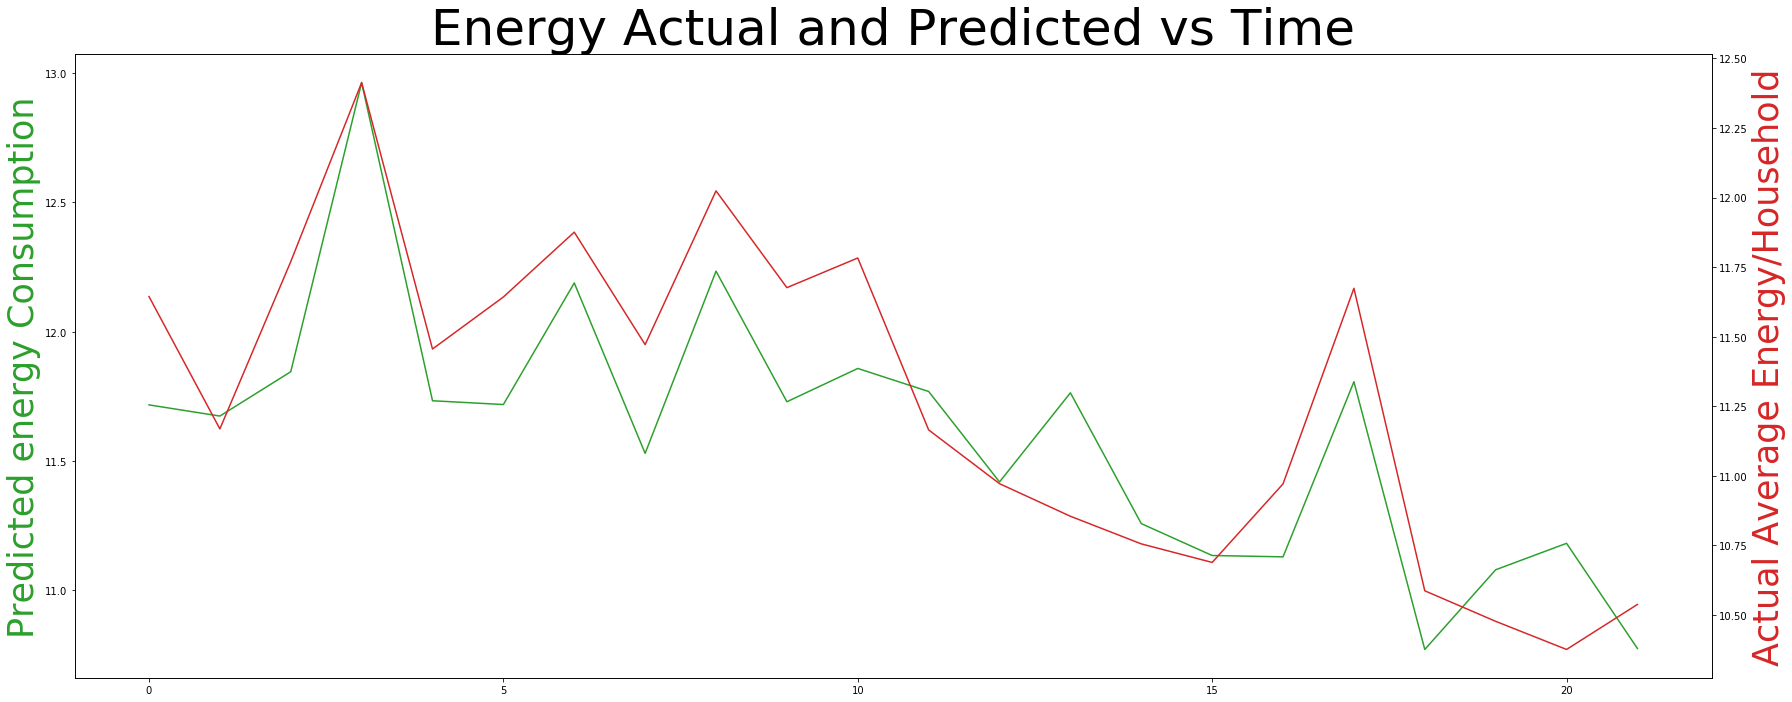

In [49]:
fig, ax1 = plt.subplots(figsize = (25,10))
ax1.plot(hybrid.index, hybrid.predicted_hybrid, color = 'tab:green')
ax1.set_ylabel('Predicted energy Consumption', color = 'tab:green', size= 35)
#ax1.legend()
ax2 = ax1.twinx()
ax2.plot(hybrid.index,hybrid.avg_energy,color = 'tab:red')
ax2.set_ylabel('Actual Average Energy/Household',color = 'tab:red', size= 35)
#ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))
plt.title('Energy Actual and Predicted vs Time', size= 50)
fig.tight_layout()
plt.show()

In [50]:
hybrid

,avg_energy,weather_cluster,holiday_ind,predicted_sarimax,residual_sarimax,predicted_lstm,residual_lstm,predicted_hybrid,residual_hybrid
0,11.644153,2,0,11.465790,0.178363,11.657823,0.013670,11.716715,0.072562
1,11.168278,2,0,11.980345,0.812067,11.698112,0.529834,11.673538,0.505260
2,11.769625,2,0,11.768506,0.001119,11.510633,0.258992,11.844915,0.075290
3,12.413253,2,0,11.752424,0.660829,11.695181,0.718072,12.962776,0.549523
4,11.455522,0,0,11.915972,0.460450,11.894554,0.439032,11.732674,0.277153
5,11.642560,2,0,11.607208,0.035352,11.626529,0.016031,11.718127,0.075567
6,11.875646,2,0,10.686739,1.188908,11.675877,0.199770,12.188154,0.312508
7,11.471329,2,0,11.405452,0.065876,11.729778,0.258449,11.529303,0.057974
8,12.024045,2,0,11.721751,0.302293,11.578453,0.445591,12.233744,0.209699
9,11.676097,2,0,11.554821,0.121276,11.859121,0.183024,11.728901,0.052804


In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Raw code"></form>''')

# Real Time Demonstration 

### Similar Approch 
<br>
<img src="files/nn.png">
<br>
Deep belief network proposed by Deng, S., et al., "Distributed electricity load forecasting model mining based on hybrid gene expression programming and cloud computing" Pattern Recognition Letters, 2017.

In [ ]:
# enter weather info - temp, humidity, windspeed; date, month, holiday, (previous enrgy consumpt)

import datetime as dt
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn import neighbors
from tkinter import *



root_main=Tk()
root_main.title("Real Time Load Forecasting")

global Enteredday_of_week, EnteredMonth, X_test, y_pred, Apt_no
global cltr
cltr = 2

def predict():
    devil = 1
    global cltr
    if float(e4.get()) < 6 and float(e5.get()) < 0.5 and float(e6.get()) < 2.5:
        cltr = -1
    elif float(e4.get()) < 12 and float(e5.get()) < 0.8 and float(e6.get()) < 4:
        cltr = 1
    if int(e7.get()) == 0:
        devil = -1
    time.sleep(4)
    if float(e3.get()) > 3.0:
        print("PREDICTED VALUE: " + str(round(float(e3.get()) + devil * 1.67 + float(e1.get()) * 0.0019 + 0.079 * float(e2.get()) + 0.33 * cltr, 3)) +  "KW")
    else:
        print("PREDICTED VALUE IS ESTIMATED TO BE BELOW 5 KW")

Label(root_main, text='Date').grid(row=1, column=0) 
Label(root_main, text='Month').grid(row=2, column=0) 
Label(root_main, text="Previous day's consumption").grid(row=3, column=0) 
Label(root_main, text='Temperature').grid(row=4, column=0) 
Label(root_main, text='humidity').grid(row=5, column=0) 
Label(root_main, text='windspeed').grid(row=6, column=0) 
Label(root_main, text='holiday').grid(row=7, column=0) 
 
e1 = Entry(root_main)
e2 = Entry(root_main)
e3 = Entry(root_main)
e4 = Entry(root_main)
e5 = Entry(root_main)
e6 = Entry(root_main)
e7 = Entry(root_main) 
e1.grid(row=1, column=1) 
e2.grid(row=2, column=1)
e3.grid(row=3, column=1)
e4.grid(row=4, column=1) 
e5.grid(row=5, column=1) 
e6.grid(row=6, column=1) 
e7.grid(row=7, column=1)

Label(root_main, text="in KW").grid(row=3, column=2) 
Label(root_main, text='in °C (typ. 12)').grid(row=4, column=2) 
Label(root_main, text='g/m^3 (typ. 0.8)').grid(row=5, column=2) 
Label(root_main, text='m/s (typ. 4)').grid(row=6, column=2) 
Label(root_main, text='0 or 1').grid(row=7, column=2)

Button(root_main,text="Predict",command=predict).grid(row=10,column=1)
root_main.mainloop()

PREDICTED VALUE: 14.528KW
PREDICTED VALUE: 11.188KW
PREDICTED VALUE: 11.188KW
PREDICTED VALUE: 11.188KW
PREDICTED VALUE: 11.188KW


<font color=red>Project Team -</font> <font color=black>Mayur Machhi, Diksha Phatak, Aniket Chavhan </font> <br> <font color=red>Project Guide -</font> <font color=black>Dr. Anil Kale</font>